In [1]:
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [2]:
graph_path = "../nevada/BG32.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

In [68]:
num_dist = 4

# Exercise: Compute exact population from your data.
pop = 2700551

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "hvap": updaters.Tally("HVAP", alias="hvap"),
    "vap": updaters.Tally("VAP", alias="vap"),
    "wvap": updaters.Tally("WVAP", alias="wvap"),
    "nh_white": updaters.Tally("NH_WHITE", alias="nh_white"),
    "hisp": updaters.Tally("HISP", alias="hisp"),
}

new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.05,
                               1)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

In [70]:
graph.nodes[0]
VAP = 0
WVAP = 0
BVAP = 0
HVAP = 0
AMINVAP = 0
NHPIVAP = 0
ASIANVAP = 0
TOTPOP = 0
NH_WHITE = 0
HISP = 0

for node in graph.nodes:
    VAP += graph.nodes[node]["VAP"]
    WVAP += graph.nodes[node]["WVAP"]
    BVAP += graph.nodes[node]["BVAP"]
    HVAP += graph.nodes[node]["HVAP"]
    AMINVAP += graph.nodes[node]["AMINVAP"]
    NHPIVAP += graph.nodes[node]["NHPIVAP"]
    ASIANVAP += graph.nodes[node]["ASIANVAP"]
    TOTPOP += graph.nodes[node]["TOTPOP"]
    NH_WHITE += graph.nodes[node]["NH_WHITE"]
    HISP += graph.nodes[node]["HISP"]
    
WVAP_Pct = WVAP / VAP
HVAP_Pct = HVAP / VAP
BVAP_Pct = BVAP / VAP
NH_WHITE_Pct = NH_WHITE / TOTPOP
HISP_Pct = HISP / TOTPOP

print("Non-Hispanic White %:", NH_WHITE_Pct)
print("Hispanic %:", HISP_Pct)

Non-Hispanic White %: 0.5414009955746069
Hispanic %: 0.2653165965019731


In [4]:
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.05,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [153]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.1),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=100000,
)

In [154]:
%%time
nh_white_pop = []
hisp_pop = []
pop = []

for step in tqdm_notebook(chain):
    nh_white_pop.append(list(step["nh_white"].values()))
    hisp_pop.append(list(step["hisp"].values()))
    pop.append(list(step["population"].values()))

CPU times: user 5h 55min 6s, sys: 2min 15s, total: 5h 57min 21s
Wall time: 5h 57min 45s


In [185]:
%%time
data_white = pd.DataFrame([sorted(list(np.divide(nh_white_pop[i], pop[i]))) for i in range(len(pop))])
data_hisp = pd.DataFrame([sorted(list(np.divide(hisp_pop[i], pop[i]))) for i in range(len(pop))])
data_minority = pd.DataFrame([sorted(list(np.divide(list(np.subtract(pop[i],nh_white_pop[i])), pop[i]))) for i in range(len(pop))])

CPU times: user 3.39 s, sys: 57.4 ms, total: 3.44 s
Wall time: 3.51 s


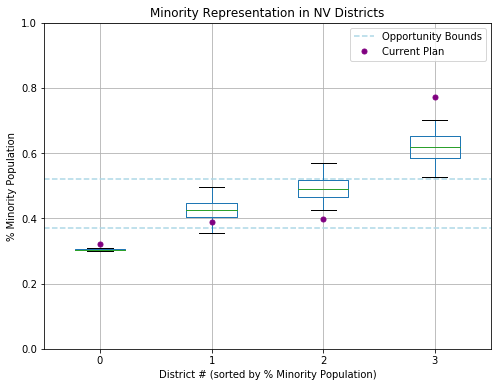

In [188]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw lines for percentages of certain races
# ax.axhline(1-NH_WHITE_Pct, color="purple", ls="--", label="Overall % Minority")
# ax.axhline(HISP_Pct, color="lightblue", ls="--", label="Overall Hispanic %")
ax.axhline(0.37, color="lightblue", ls="--", label="Opportunity Bounds")
ax.axhline(0.52, color="lightblue", ls="--")


# Draw boxplot
# data_hisp.boxplot(ax=ax, positions=range(len(data_hisp.columns)), whis=[1,99], showfliers=False)
data_minority.boxplot(ax=ax, positions=range(len(data_minority.columns)), whis=[1,99], showfliers=False)

# Current Plans
# HVAP_Pct_real = [.154,.211,.302,.429]
# WVAP_Pct_real = [.229,.602,.610,.680]
minority_Pct_real = [1-.680, 1-.610,1-.602,1-.229]

# Changing the y-axis range
ax.set_ylim(0,1)

# Plot points of actual HVAP_Pct in current plan
# ax.plot([0,1,2,3],HVAP_Pct_real, 'o', color="blue", label="Current Plan" markersize=5)
# ax.plot([0,1,2,3],WVAP_Pct_real, 'o', color="orange", label="Current Plan", markersize=5)
ax.plot([0,1,2,3],minority_Pct_real, 'o', color="purple", label="Current Plan", markersize=5)

# Annotate
ax.set_title("Minority Representation in NV Districts")
ax.set_ylabel("% Minority Population")
ax.set_xlabel("District # (sorted by % Minority Population)")
ax.legend(loc="best")

plt.show()

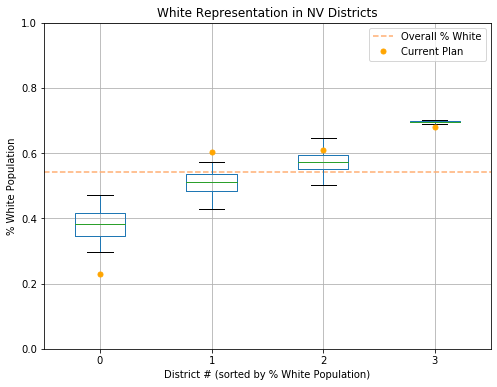

In [180]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw lines for percetanges of certain races
ax.axhline(NH_WHITE_Pct, color="#ffaf72", ls="--", label="Overall % White")
# ax.axhline(HISP_Pct, color="lightblue", ls="--", label="Overall Hispanic %")

# Draw boxplot
# data_hisp.boxplot(ax=ax, positions=range(len(data_hisp.columns)), whis=[1,99], showfliers=False)
data_white.boxplot(ax=ax, positions=range(len(data_white.columns)), whis=[1,99], showfliers=False)

# Current Plans
# HVAP_Pct_real = [.154,.211,.302,.429]
WVAP_Pct_real = [.229,.602,.610,.680]

# Changing the y-axis range
ax.set_ylim(0,1)

# Plot points of actual HVAP_Pct in current plan
# ax.plot([0,1,2,3],HVAP_Pct_real, 'o', color="blue", label="Current Plan" markersize=5)
ax.plot([0,1,2,3],WVAP_Pct_real, 'o', color="orange", label="Current Plan", markersize=5)

# Annotate
ax.set_title("White Representation in NV Districts")
ax.set_ylabel("% White Population")
ax.set_xlabel("District # (sorted by % White Population)")
ax.legend(loc="best")

plt.show()

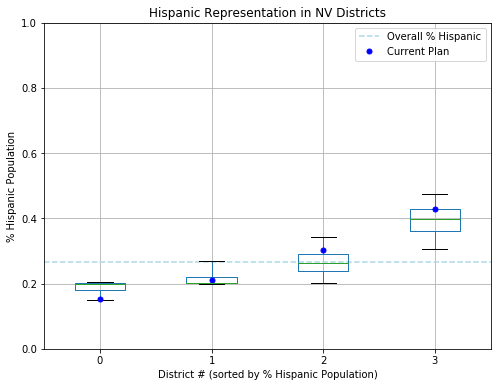

In [179]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw lines for percetanges of certain races
# ax.axhline(NH_WHITE_Pct, color="#ffaf72", ls="--", label="Overall White %")
ax.axhline(HISP_Pct, color="lightblue", ls="--", label="Overall % Hispanic")

# Draw boxplot
data_hisp.boxplot(ax=ax, positions=range(len(data_hisp.columns)), whis=[1,99], showfliers=False)
# data_white.boxplot(ax=ax, positions=range(len(data_white.columns)), whis=[1,99], showfliers=False)

# Current Plans
HVAP_Pct_real = [.154,.211,.302,.429]
# WVAP_Pct_real = [.229,.602,.610,.680]

# Changing the y-axis range
ax.set_ylim(0,1)

# Plot points of actual HVAP_Pct in current plan
ax.plot([0,1,2,3],HVAP_Pct_real, 'o', color="blue", label="Current Plan", markersize=5)
# ax.plot([0,1,2,3],WVAP_Pct_real, 'o', color="orange", label="Current Plan", markersize=5)

# Annotate
ax.set_title("Hispanic Representation in NV Districts")
ax.set_ylabel("% Hispanic Population")
ax.set_xlabel("District # (sorted by % Hispanic Population)")
ax.legend(loc="best")

plt.show()